<a href="https://colab.research.google.com/github/yijingxu/Marketing-Analysis/blob/main/Baseline_Model%2C_GRU%2C_and_Inception_CNN%2B_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

# Code to read csv file into Colaboratory:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
link = 'https://drive.google.com/file/d/15QW4U8IZY5_JakMhobgtTNExCzmuGGTK/view?usp=share_link' # The shareable link
id = '15QW4U8IZY5_JakMhobgtTNExCzmuGGTK'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('price_load_gas_1_year.csv')  
df = pd.read_csv('price_load_gas_1_year.csv', index_col=0).reset_index(drop=True)

In [3]:
df = df.iloc[:,1:3]

In [4]:
print(df.shape)
df.head()

(8909, 2)


,log_ret_price,log_ret_ercot_load
0,0.741885,0.035744
1,0.020011,0.059710
2,-0.262552,0.030095
3,-0.109985,0.008640
4,-0.121353,0.001144


In [5]:
float_data = np.asarray([np.asarray(row) for row in df.values])

In [6]:
float_data.shape

(8909, 2)

In [7]:
# Data Preprocessing
# This function generate a dataframe containing all the 'feature', 'Non-null-count', 'dtype','number_of_unique_values', 'unique_values','mean','standard deviation' for variables 
def info_df_generator(df):
    lt = []
    for col in df.columns:
        col_non_null_count = df[col].count()
        cell_type= df[col].dtypes
        mean_value = df[col].mean() if cell_type != 'object' else "-"
        std_value = df[col].std() if cell_type != 'object' else "-"
        lt.append([col, col_non_null_count,cell_type, mean_value, std_value])
    info_df = pd.DataFrame(lt, columns = ['feature', 'Non-null-count', 'dtype', 'mean','standard deviation'])
    return(info_df)
info_df_generator(df)

,feature,Non-null-count,dtype,mean,standard deviation
0,log_ret_price,8909,float64,-0.000010,0.228948
1,log_ret_ercot_load,8909,float64,0.000012,0.037919


# Stationarity

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=24).mean()
    movingSTD = timeseries.rolling(window=24).std()
    #print(movingAverage)
    #print(movingSTD)
    
    #Plot rolling statistics
    plt.figure(figsize = (10,8))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # #Perform Dickey–Fuller test:
    # from statsmodels.tsa.stattools import adfuller
    # print('Results of Dickey Fuller Test:')
    # dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    # dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    # for key,value in dftest[4].items():
    #     dfoutput['Critical Value (%s)'%key] = value
    # print(dfoutput)

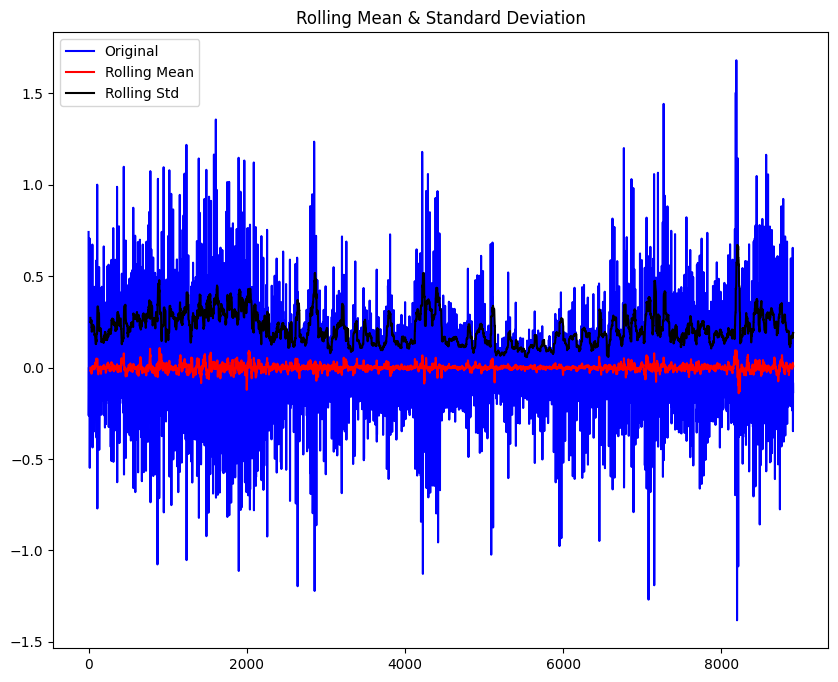

In [9]:
test_stationarity(df['log_ret_price'])

In [10]:
def dickey_fuller_test(df = df):
    print('Results of Dickey Fuller Test:')

    dickey_fuller = {}
    for col in df.columns:

        from statsmodels.tsa.stattools import adfuller
        dftest = adfuller(df[col], autolag='AIC')

        dfoutput = pd.Series(dftest[0:4], 
                            index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
            dickey_fuller[col] = dfoutput
    return pd.DataFrame(dickey_fuller)
dickey_fuller_test(df = df)

Results of Dickey Fuller Test:


,log_ret_price,log_ret_ercot_load
Test Statistic,-20.130066,-1.560368e+01
p-value,0.000000,1.815900e-28
#Lags Used,28.000000,3.600000e+01
Number of Observations Used,8880.000000,8.872000e+03
Critical Value (1%),-3.431087,-3.431087e+00
Critical Value (5%),-2.861866,-2.861866e+00
Critical Value (10%),-2.566943,-2.566943e+00


<h2> Hyperparameters:
<li>lookback: how many timesteps back the input data should go: - I choose 168 here for go back 7 days
<li>delay: how many timesteps in the future the target should be: I choose 24 here to predict a day
<li>min_index and max_index: indices in the data array that delimit which timesteps to draw from. This is used to devide train, validation, and test
<li>shuffle: whether to shuffle the samples or draw them in chronological order. We did not shuffle here, but we can
<li>batch_size: the number of samples per batch
<li>step: the period in timestamps at which you sample data. I set it to 1 in order to draw one data point every hour

In [11]:
#lookback: how many timesteps back the input data should go: 168
#delay: how many timesteps in the future the target should be: 24
#min_index and max_index are indices in the data array that delimit which timesteps to draw from. 
#shuffle: whether to shuffle the samples or draw them in chronological order 
#batch_size: the number of samples per batch
#step:the period in timestamps at which you sample data. You'll set it to 1 in order to draw one data point every hour

def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 64, step = 1):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
    #This line starts an infinite loop.
    #This block of code determines which rows of data to use in the batch. 
    #If shuffle is True, it randomly selects batch_size rows between min_index + lookback and max_index. 
    #If shuffle is False, it selects batch_size consecutive rows starting from i,
    # where i is incremented by the number of rows selected in each iteration of the loop.
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i,min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.empty((len(rows),
                           lookback//step,
                           data.shape[-1]))
        targets = np.empty((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        yield samples,targets

In [12]:
df.shape

(8909, 2)

In [13]:
lookback = 168
step = 1
delay = 1
batch_size = 128

train_val_split = 8186
val_test_split = 8600+12 

train_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 0,
                     max_index = train_val_split, shuffle = True, step = step, batch_size=batch_size)
val_gen = generator(float_data, lookback = lookback, delay = delay, min_index = train_val_split+1,
                     max_index = val_test_split, shuffle = True, step = step, batch_size=batch_size)
test_gen = generator(float_data, lookback = lookback, delay = delay, min_index = val_test_split+1,
                     max_index = None, shuffle = False, step = step, batch_size=batch_size)

#how many steps to draw from val_gen in order to see the entire validation set
train_steps = (train_val_split - lookback - delay)//batch_size
val_steps = (val_test_split - train_val_split - lookback - delay)//batch_size
#how many steps to draw from test_gen in order to see the entire test set
test_steps = (len(df) - val_test_split - lookback - delay)//batch_size

In [14]:
test_steps

1

# Computing the Common-sense Baseline MAE
<li>a naive method for predicting the targets based on the last observed value in the input data

In [15]:
def evaluate_naive_method():
    # batch_maes = []
    # pred_result = []
    # test_result = []
    
    # for step in range(test_steps):
    samples, targets = next(test_gen)
    preds = samples[:, -1,0]
    mae = np.mean(np.abs(preds - targets))
        # batch_maes.append(mae)
        # pred_result.append(preds)
        # test_result.append(targets)
    return mae,preds, targets

In [16]:
naive_method_mae, naive_pred_result, naive_test_result = evaluate_naive_method()

In [17]:
naive_method_mae

0.1992340912986217

In [18]:
def test_vs_pred_plot(pred_result,test_result):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import mean_squared_error
    
    p = np.array(pred_result)
    t = np.array(test_result)
    
    # if len(p.shape) == 3:
    #     p = np.squeeze(p, axis=-1)
    # if len(t.shape) == 3:
    #     t = np.squeeze(t, axis=-1)
    
    # p = np.ravel(p)
    # t = np.ravel(t)
    
    # Calculate the mean squared error (MSE) between the two arrays
    mse = mean_squared_error(p,t)
    print(mse)
    
    # p = p[-24:]
    # t = t[-24:]
    
    # Plot the two arrays
    plt.figure(figsize=(30, 10))
    
    plt.plot(t, color='lightsalmon', label='Test Result')
    plt.plot(p, color='black',label='Predicted Result')

    # Add the MSE to the plot as the title
    plt.title('Mean Squared Error: {:.2f}'.format(mse))
    
    # Add a legend to the plot
    plt.legend()

    # Show the plot
    plt.show()

0.09703491780096889


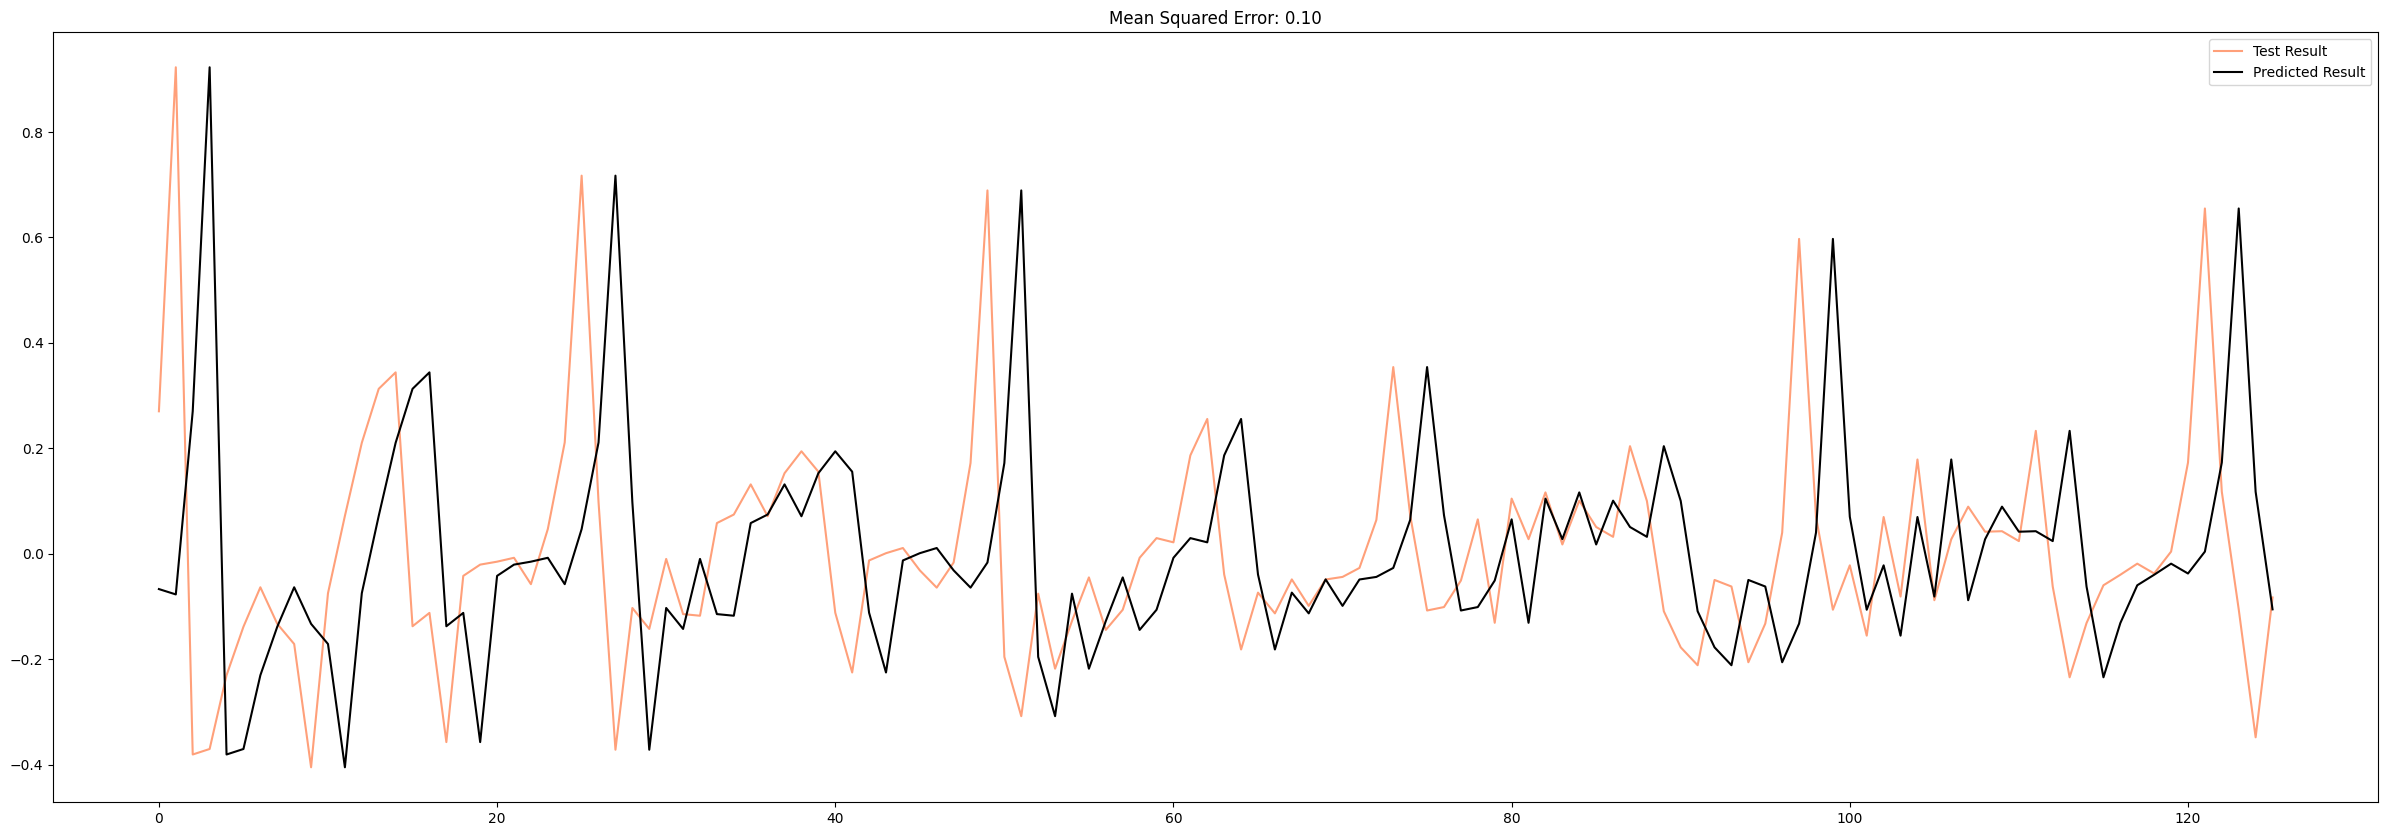

In [19]:
test_vs_pred_plot(naive_pred_result, naive_test_result)

In [20]:
# convert the mae back to error in dollars
print('mae on scaled data for baseline naive model is:', naive_method_mae)
#print('mean absolute error for naive method is:', naive_method_mae)

mae on scaled data for baseline naive model is: 0.1992340912986217


# Baseline Deep Learning Model 
<li> before looking into complicated and computationally expensive models such as RNN, it's useful to try a small, densly connected network
<li> This is the best way to make sure any further complexity we throw at the problem is legitimate and delivers real benefits

In [21]:
from keras.models import Sequential 
from keras import layers 
from keras.optimizers import RMSprop

m = Sequential()
m.add(layers.Flatten(input_shape = (lookback//step, float_data.shape[-1])))
m.add(layers.Dense(32, activation = 'relu'))
m.add(layers.Dense(1))
m.compile(optimizer = RMSprop(), loss = 'mae')

h = m.fit(train_gen,
           steps_per_epoch = 500,
           epochs = 40,
           validation_data = val_gen,
           validation_steps = 1)


Epoch 1/40
500/500 [==============================] - 9s 13ms/step - loss: 0.0962 - val_loss: 0.1214
Epoch 2/40
500/500 [==============================] - 5s 10ms/step - loss: 0.0786 - val_loss: 0.1310
Epoch 3/40
500/500 [==============================] - 5s 9ms/step - loss: 0.0742 - val_loss: 0.1356
Epoch 4/40
500/500 [==============================] - 5s 11ms/step - loss: 0.0702 - val_loss: 0.1345
Epoch 5/40
500/500 [==============================] - 3s 6ms/step - loss: 0.0661 - val_loss: 0.1429
Epoch 6/40
500/500 [==============================] - 3s 6ms/step - loss: 0.0643 - val_loss: 0.1549
Epoch 7/40
500/500 [==============================] - 3s 6ms/step - loss: 0.0616 - val_loss: 0.1490
Epoch 8/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0598 - val_loss: 0.1469
Epoch 9/40
500/500 [==============================] - 3s 6ms/step - loss: 0.0579 - val_loss: 0.1249
Epoch 10/40
500/500 [==============================] - 3s 6ms/step - loss: 0.0570 - val_loss: 0.1

In [22]:
def model_performance(model):
    batch_maes = []
    pred_result = []
    test_result = []
    
    for step in range(test_steps):
        samples, targets = next(test_gen)
        preds = model.predict(samples)
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        pred_result.append(preds)
        test_result.append(targets)
        
    return np.mean(batch_maes), pred_result, test_result
t_mae, p_result, t_result = model_performance(m)

4/4 [==============================] - 0s 2ms/step


In [23]:
def in_sample_performance(model):
    for step in range(train_steps): 
        samples, targets = next(train_gen)
        preds = model.predict(samples)
        mae = np.mean(np.abs(preds - targets))
    return mae
in_sample_performance(m)

4/4 [==============================] - 0s 3ms/step


0.2618490867657576

In [24]:
def test_vs_pred_plot(pred_result,test_result):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import mean_squared_error
    
    p = np.array(pred_result)
    t = np.array(test_result)
    
    if len(p.shape) == 3:
        p = np.squeeze(p, axis=-1)
    if len(t.shape) == 3:
        t = np.squeeze(t, axis=-1)
    
    p = np.ravel(p)
    t = np.ravel(t)
    
    # Calculate the mean squared error (MSE) between the two arrays
    mse = mean_squared_error(p,t)
    print(mse)
    
    # p = p[-24:]
    # t = t[-24:]
    
    # Plot the two arrays
    plt.figure(figsize=(30, 10))
    
    plt.plot(t, color='lightsalmon', label='Test Result')
    plt.plot(p, color='black',label='Predicted Result')

    # Add the MSE to the plot as the title
    plt.title('Mean Squared Error: {:.2f}'.format(mse))
    
    # Add a legend to the plot
    plt.legend()

    # Show the plot
    plt.show()

In [25]:
t_mae

0.2318146589115399

0.029823242038090635


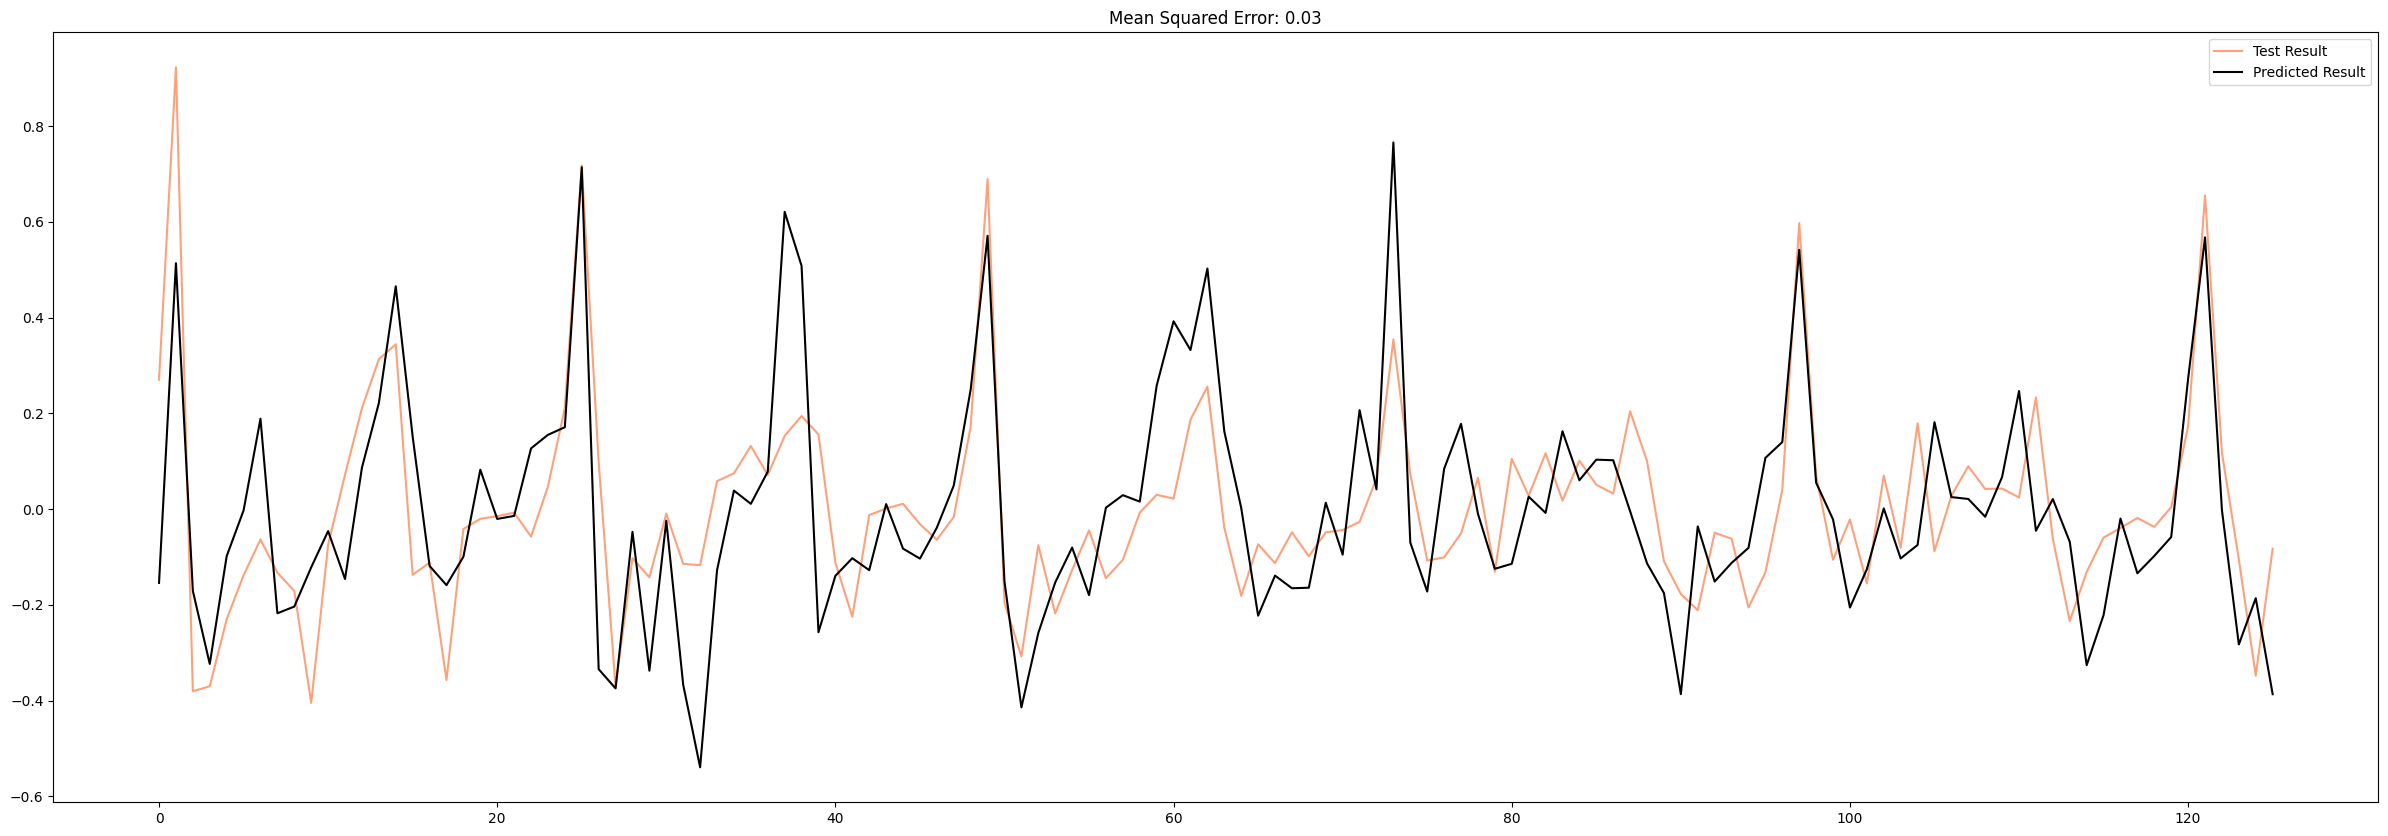

In [26]:
test_vs_pred_plot(p_result, t_result)

# GRU Model: Training and Evaluating a GRU based model 
<li> a first recurrent baseline
<li> instead of the LSTM layer introduced in the previous section, I use the GRU layer.
<li> GRU(Gated Recurrent Network) layers work using the same principle as LSTM, but they are somewhat streamlined and thus cheaper to run(although they might not have as much representational power as LSTM).
<li>"val_loss" is one of the monitored metrics and corresponds to the validation loss at each epoch of the training process. It is used to evaluate the performance of the model on the validation data over time and to identify when the model starts to overfit or underfit the data.
    

In [ ]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, concatenate, LSTM, Dense, LeakyReLU,Dropout
from keras.optimizers import RMSprop

model2 = Sequential()
model2.add(layers.GRU(32,activation = LeakyReLU(alpha=0.01),
                     dropout = 0.1,
                     recurrent_dropout = 0.5,
                     return_sequences = True, 
                     input_shape = (None, float_data.shape[-1])))
model2.add(layers.GRU(64,activation = LeakyReLU(alpha=0.01),
                     dropout = 0.1,
                     recurrent_dropout = 0.5,
                    return_sequences = True))
model2.add(layers.GRU(128,activation = LeakyReLU(alpha=0.01),
                     dropout = 0.1,
                     recurrent_dropout = 0.5))

model2.add(layers.Dense(1))

model2.compile(optimizer = RMSprop(), loss = 'mae')

# define early stopping callback
early_stop2 = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

# train the model with early stopping
history2 = model2.fit(train_gen,
                    steps_per_epoch=20,
                    epochs=100,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    callbacks=[early_stop2])


Epoch 1/100
20/20 [==============================] - 41s 2s/step - loss: 0.1483 - val_loss: 0.1586
Epoch 2/100
20/20 [==============================] - 35s 2s/step - loss: 0.1433 - val_loss: 0.1685
Epoch 3/100
20/20 [==============================] - 34s 2s/step - loss: 0.1401 - val_loss: 0.1724
Epoch 4/100
 6/20 [========>.....................] - ETA: 20s - loss: 0.1273

In [ ]:
def model_performance(model):
    import math

    samples, targets = next(test_gen)
    preds = model.predict(samples)

    #targets = np.array([math.exp(i) for i in targets])

    #preds = np.array([math.exp(i) for i in preds])
    
    mae = np.mean(np.abs(preds - targets))
        
    return mae, preds, targets

# def model_performance(model):
#     batch_maes = []
#     pred_result = []
#     test_result = []
    
#     for step in range(test_steps):
#         samples, targets = next(test_gen)
#         preds = model.predict(samples)
#         mae = np.mean(np.abs(preds - targets))
#         batch_maes.append(mae)
#         pred_result.append(preds)
#         test_result.append(targets)
        
#     return np.mean(batch_maes), pred_result, test_result

In [ ]:
import matplotlib.pyplot as plt

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()

plt.plot(epochs, loss,'bo', label = 'Training loss')
plt.plot(epochs, val_loss,'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
# from keras.models import load_model

# # Save the trained model
# model.save('gru_doublelayer_model2-24hoursawayprediction.h5')
# from google.colab import files

# # Download the saved model file to your local machine
# files.download('gru_doublelayer_model2.h5')
in_sample_performance(model2)

In [ ]:
test_mae2, pred_result2, test_result2 = model_performance(model = model2)

In [ ]:
print('mae on scaled data for one layer simple GRU model is:', test_mae2)
#print('mean absolute error for one layer simple GRU model is:', test_mae*267.4953949358713)

In [ ]:
test_vs_pred_plot(pred_result2, test_result2)

In [ ]:
in_sample_performance(model2)

# LSTM

In [ ]:
from keras.models import Sequential 
from keras import layers
from keras.optimizers import RMSprop
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, concatenate, LSTM, Dense, LeakyReLU, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

model3 = Sequential()
model3.add(layers.LSTM(32, activation=LeakyReLU(alpha=0.01),
                       dropout=0.1,
                       recurrent_dropout=0.5,
                       return_sequences=True, 
                       input_shape=(None, float_data.shape[-1])))
model3.add(layers.LSTM(64, activation=LeakyReLU(alpha=0.01),
                       dropout=0.1,
                       recurrent_dropout=0.5,
                       return_sequences=True))
model3.add(layers.LSTM(128, activation=LeakyReLU(alpha=0.01),
                       dropout=0.1,
                       recurrent_dropout=0.5))

model3.add(layers.Dense(1))

model3.compile(optimizer=RMSprop(), loss='mae')

# define early stopping callback
early_stop3 = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

# train the model with early stopping
history3 = model3.fit(train_gen,
                      steps_per_epoch=20,
                      epochs=200,
                      validation_data=val_gen,
                      validation_steps=val_steps,
                      callbacks=[early_stop3])


In [ ]:
# def model_performance(model):
#     import math

#     samples, targets = next(test_gen)
#     preds = model.predict(samples)

#     #targets = np.array([math.exp(i) for i in targets])

#     #preds = np.array([math.exp(i) for i in preds])
    
#     mae = np.mean(np.abs(preds - targets))
        
#     return mae, preds, targets

def model_performance(model):
    batch_maes = []
    pred_result = []
    test_result = []
    
    for step in range(test_steps):
        samples, targets = next(test_gen)
        preds = model.predict(samples)
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        pred_result.append(preds)
        test_result.append(targets)
        
    return np.mean(batch_maes), pred_result, test_result

In [ ]:
test_mae3, pred_result3, test_result3 = model_performance(model = model3)

In [ ]:
in_sample_performance(model3)

In [ ]:
test_vs_pred_plot(pred_result3, test_result3)

# Inception CNN + LSTM



In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, concatenate, LSTM, Dense, LeakyReLU,Dropout
from keras.optimizers import RMSprop

# input layer for the time series data
input_ts = Input(shape=(None, float_data.shape[-1]))

# first inception block
conv1 = Conv1D(32, 1, activation=LeakyReLU(alpha=0.01), padding='same')(input_ts)

conv3_reduce = Conv1D(32, 1, activation=LeakyReLU(alpha=0.01), padding='same')(input_ts)
conv3 = Conv1D(32, 3, activation=LeakyReLU(alpha=0.01), padding='same')(conv3_reduce)

conv5_reduce = Conv1D(32, 1, activation=LeakyReLU(alpha=0.01), padding='same')(input_ts)
conv5 = Conv1D(32, 5, activation=LeakyReLU(alpha=0.01), padding='same')(conv5_reduce)

maxpool = MaxPooling1D(pool_size=3, strides=1, padding='same')(input_ts)
maxpool_conv = Conv1D(32, 1, activation=LeakyReLU(alpha=0.01), padding='same')(maxpool)

inception_output = concatenate([conv1, conv3, conv5, maxpool_conv])
inception_output = Dropout(0.2)(inception_output)

# second inception block
conv1 = Conv1D(32, 1, activation=LeakyReLU(alpha=0.01), padding='same')(inception_output)

conv3_reduce = Conv1D(32, 1, activation=LeakyReLU(alpha=0.01), padding='same')(inception_output)
conv3 = Conv1D(32, 3, activation=LeakyReLU(alpha=0.01), padding='same')(conv3_reduce)

conv5_reduce = Conv1D(32, 1, activation=LeakyReLU(alpha=0.01), padding='same')(inception_output)
conv5 = Conv1D(32, 5, activation=LeakyReLU(alpha=0.01), padding='same')(conv5_reduce)

maxpool = MaxPooling1D(pool_size=3, strides=1, padding='same')(inception_output)
maxpool_conv = Conv1D(32, 1, activation=LeakyReLU(alpha=0.01), padding='same')(maxpool)

inception_output = concatenate([conv1, conv3, conv5, maxpool_conv])
inception_output = Dropout(0.2)(inception_output)

# LSTM layer
lstm_output = LSTM(32, activation=LeakyReLU(alpha=0.01),
                   dropout=0.1, recurrent_dropout=0.5,
                   return_sequences=True)(inception_output)

lstm_output = LSTM(64, activation=LeakyReLU(alpha=0.01),
                   dropout=0.1, recurrent_dropout=0.5,
                   return_sequences=True)(lstm_output)

lstm_output = LSTM(128, activation=LeakyReLU(alpha=0.01),
                   dropout=0.1, recurrent_dropout=0.5)(lstm_output)

# output layer
output = Dense(1)(lstm_output)

# define the model
model = Model(inputs=input_ts, outputs=output)

# compile the model
model.compile(optimizer=RMSprop(), loss='mae')

from keras.callbacks import EarlyStopping

# define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

# train the model with early stopping
history = model.fit(train_gen,
                    steps_per_epoch=20,
                    epochs=100,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    callbacks=[early_stop])


In [ ]:
# from keras.models import load_model

# # Save the trained model
# model.save('inceptioncnn+lstm-prediction.h5')
in_sample_performance(model)

In [ ]:
t_mae, p_result, t_result = model_performance(model)

In [ ]:
print('mae on scaled data for Incep CNN + LSTM deep learning model is:', t_mae)
#print('mean absolute error for baseline deep learning model is:', t_mae*267.4953949358713)

In [ ]:
def test_vs_pred_plot(pred_result,test_result):
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import mean_squared_error
    
    p = np.array(pred_result)
    t = np.array(test_result)
    
    if len(p.shape) == 3:
        p = np.squeeze(p, axis=-1)
    if len(t.shape) == 3:
        t = np.squeeze(t, axis=-1)
    
    p = np.ravel(p)
    t = np.ravel(t)
    
    # Calculate the mean squared error (MSE) between the two arrays
    mse = mean_squared_error(p,t)
    print(mse)
    
    # p = p[-24:]
    # t = t[-24:]
    
    # Plot the two arrays
    plt.figure(figsize=(30, 10))
    
    plt.plot(t, color='lightsalmon', label='Test Result')
    plt.plot(p, color='black',label='Predicted Result')

    # Add the MSE to the plot as the title
    plt.title('Mean Squared Error: {:.2f}'.format(mse))
    
    # Add a legend to the plot
    plt.legend()

    # Show the plot
    plt.show()
test_vs_pred_plot(p_result, t_result)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.figure()

plt.plot(epochs, loss,'bo', label = 'Training loss')
plt.plot(epochs, val_loss,'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()